# Data visualization
---
- Interpretting the data visually and through statistics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
vir_col = plt.get_cmap("viridis")
plt.style.use("ggplot")
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

In [3]:
train_data = pd.read_pickle("clean_data/train_clean.pkl")
test_data = pd.read_pickle("clean_data/test_clean.pkl")

In [4]:
train_data.head(3)

,Sales,Customers,Store,Date,DayOfWeek,Week,Month,Year,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Competition,LogCompetitionDistance,CompetitionMonthsTotal,Promo2,Promo2MonthsTotal,Promo2CurrentlyOn
0,5263,555,1,2015-07-31,5,31,7,2015,1,1,0,1,c,a,1,7.146772,82,0,0.00,0
1,6064,625,2,2015-07-31,5,31,7,2015,1,1,0,1,a,a,1,6.345636,92,1,64.50,1
2,8314,821,3,2015-07-31,5,31,7,2015,1,1,0,1,a,a,1,9.556055,103,1,52.25,1


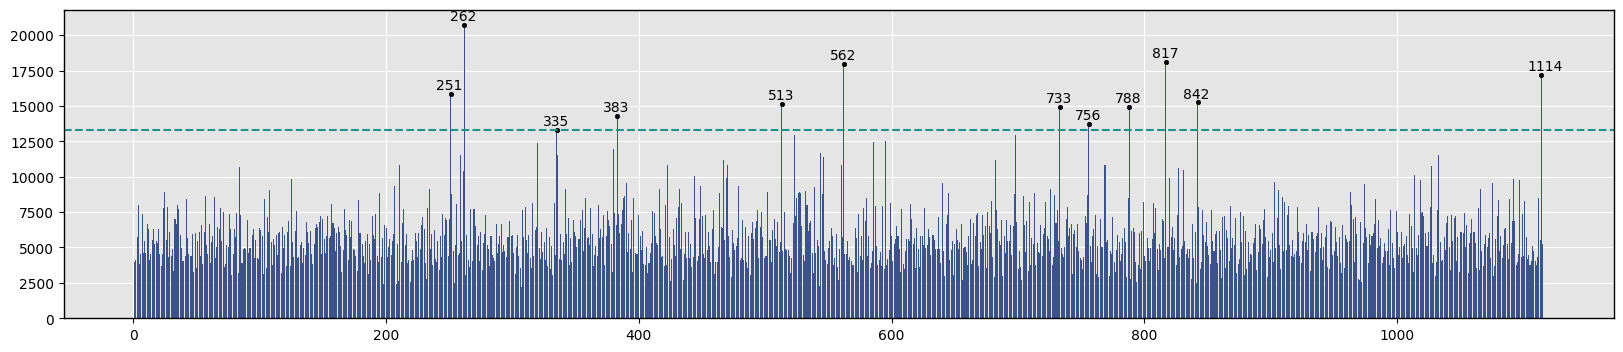

In [5]:
average_store_sales = train_data.groupby("Store").Sales.mean()
mean_quantile_95 = train_data.groupby("Store").Sales.mean().quantile(0.99)
better_than_q95 = average_store_sales[average_store_sales > mean_quantile_95]

fig, ax = plt.subplots(figsize=(20, 4))

ax.bar(average_store_sales.index, average_store_sales, color=vir_col(0.25))
ax.axhline(mean_quantile_95, linestyle="--", c=vir_col(0.5))
ax.scatter(better_than_q95.index, better_than_q95, c="black", s=10)

for store_id, value in better_than_q95.items():
    ax.annotate(str(store_id), (store_id - 0.01 * average_store_sales.shape[0], value + 0.025 * min(better_than_q95)))

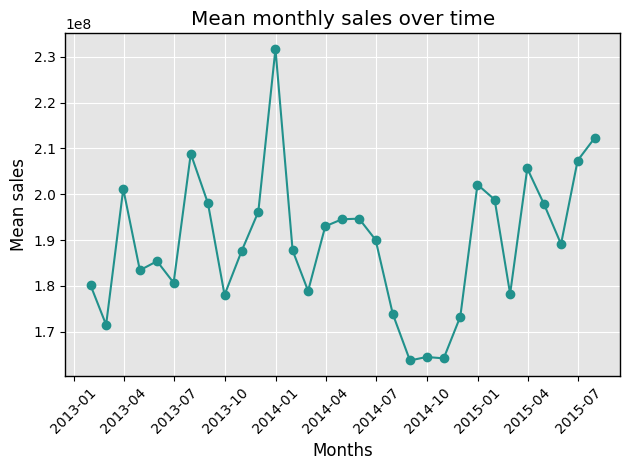

In [6]:
monthly_sales = train_data.groupby(pd.Grouper(key="Date", freq="ME")).Sales.sum()
fig, ax = plt.subplots(layout="tight")

ax.plot(monthly_sales.index, monthly_sales.values, "o-", color=vir_col(0.5))

ax.set_title("Mean monthly sales over time")
ax.set_xlabel("Months")
ax.set_ylabel("Mean sales")
ax.tick_params(axis="x", rotation=45)
ax.grid(True)

/tmp/ipykernel_286088/1200461615.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


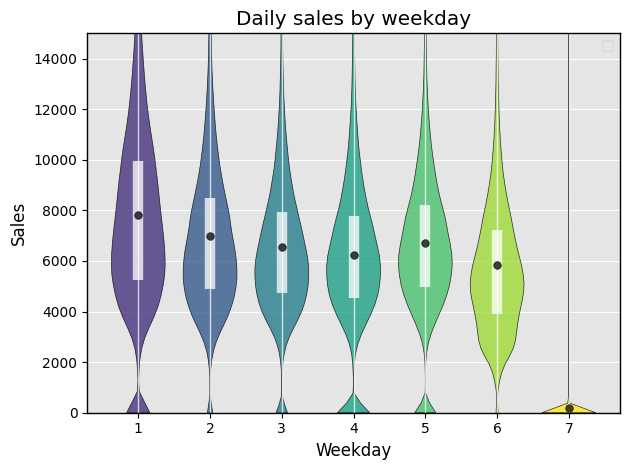

In [7]:
data_by_weekday = train_data.groupby("DayOfWeek")["Sales"].agg(list)

fig, ax = plt.subplots(layout="tight")

parts = ax.violinplot(data_by_weekday.tolist(), positions=range(1, len(data_by_weekday)+1), showextrema=False, widths=0.75)
for i, pc in enumerate(parts["bodies"]):
    pc.set_facecolor(vir_col((1 + i)* 1 / len(parts["bodies"])))
    pc.set_edgecolor("black")
    pc.set_alpha(0.8)

mean_values = train_data.groupby("DayOfWeek")["Sales"].mean()
quartile_1 = train_data.groupby("DayOfWeek")["Sales"].quantile(0.75)
quartile_3 = train_data.groupby("DayOfWeek")["Sales"].quantile(0.25)
ax.scatter(mean_values.index, mean_values, c="black", s=30, edgecolors="black", zorder=5, alpha=0.75)
ax.vlines(quartile_1.index, quartile_1, quartile_3, color="white", linewidth=7.5, alpha=0.75)
ax.vlines(quartile_1.index, 0, 15000, color="white", linewidth=1, alpha=0.75)

ax.set_title("Daily sales by weekday")
ax.set_xlabel("Weekday")
ax.set_ylabel("Sales")
ax.set_ylim(0, 15000)
ax.grid(True)
ax.legend()


/tmp/ipykernel_286088/2398202373.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_type_totals = train_data[["Store", "StoreType"]].drop_duplicates().groupby("StoreType").size().reset_index(name="Count")


Text(0, 0.5, 'Total sales per store')

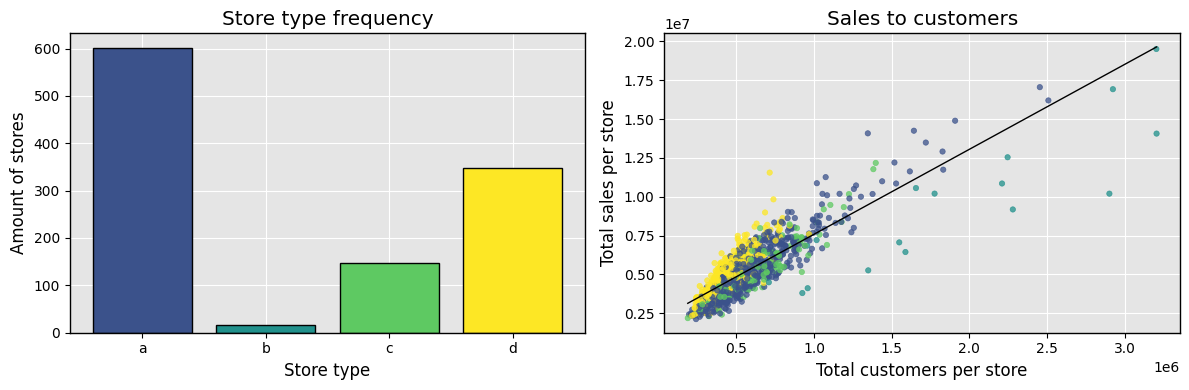

In [8]:
total_sales_to_customers = train_data.groupby("Store").agg({
    "Sales": "sum",
    "Customers": "sum",
    "StoreType": "first"
})

def get_color_list(col_param, variable):
    unique_values = train_data[variable].unique()
    color_list = {val: vir_col((i + col_param) * 1 / len(unique_values)) for i, val in enumerate(unique_values.sort_values())}
    return color_list

total_sales_to_customers["Colors"] = total_sales_to_customers.StoreType.astype(str).map(get_color_list(1, "StoreType"))
store_type_totals = train_data[["Store", "StoreType"]].drop_duplicates().groupby("StoreType").size().reset_index(name="Count")
store_type_totals["Colors"] = store_type_totals["StoreType"].astype(str).map(get_color_list(1, "StoreType"))

lin_mod = linregress(total_sales_to_customers["Customers"], total_sales_to_customers["Sales"])
x_for_model = np.linspace(min(total_sales_to_customers["Customers"]), max(total_sales_to_customers["Customers"]), num=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, layout="tight", figsize=(12, 4))
ax1.bar(store_type_totals.StoreType, store_type_totals.Count, color=store_type_totals.Colors, edgecolor="black", linewidth=1)
ax1.set_title("Store type frequency")
ax1.set_xlabel("Store type")
ax1.set_ylabel("Amount of stores")
ax2.scatter(total_sales_to_customers.Customers, total_sales_to_customers.Sales, c=total_sales_to_customers.Colors, s=15, alpha=0.75)
ax2.plot(x_for_model, lin_mod.intercept + x_for_model * lin_mod.slope, c="black", linewidth=1)
ax2.set_title("Sales to customers")
ax2.set_xlabel("Total customers per store")
ax2.set_ylabel("Total sales per store")

/tmp/ipykernel_286088/2108204391.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_type_totals = train_data[["Store", "Assortment"]].drop_duplicates().groupby("Assortment").size().reset_index(name="Count")
/tmp/ipykernel_286088/2108204391.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(["basic", "extra", "extended"])


Text(0, 0.5, 'Total sales per store')

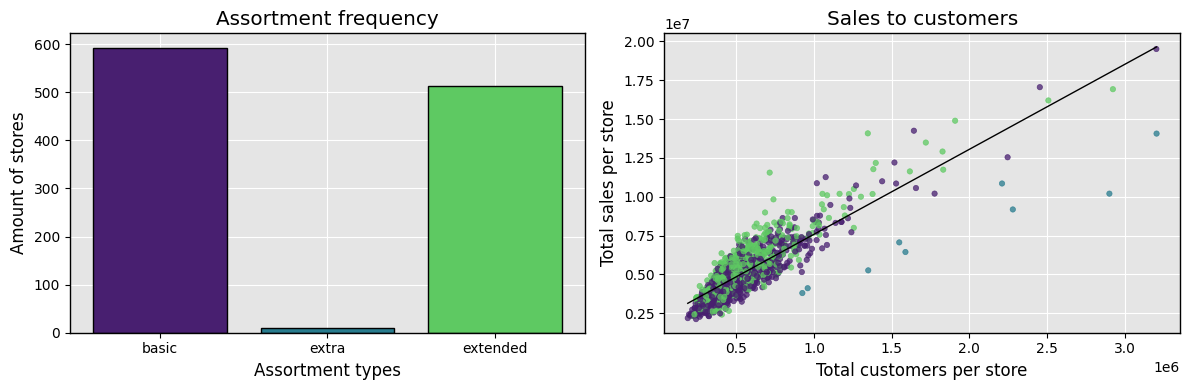

In [9]:
total_sales_to_customers = train_data.groupby("Store").agg({
    "Sales": "sum",
    "Customers": "sum",
    "Assortment": "first"
})

total_sales_to_customers["Colors"] = total_sales_to_customers.Assortment.astype(str).map(get_color_list(0.25, "Assortment"))
store_type_totals = train_data[["Store", "Assortment"]].drop_duplicates().groupby("Assortment").size().reset_index(name="Count")
store_type_totals["Colors"] = store_type_totals["Assortment"].astype(str).map(get_color_list(0.25, "Assortment"))

lin_mod = linregress(total_sales_to_customers["Customers"], total_sales_to_customers["Sales"])
x_for_model = np.linspace(min(total_sales_to_customers["Customers"]), max(total_sales_to_customers["Customers"]), num=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, layout="tight", figsize=(12, 4))
ax1.bar(store_type_totals.Assortment, store_type_totals.Count, color=store_type_totals.Colors, edgecolor="black", linewidth=1)
ax1.set_title("Assortment frequency")
ax1.set_xlabel("Assortment types")
ax1.set_ylabel("Amount of stores")
ax1.set_xticklabels(["basic", "extra", "extended"])
ax2.scatter(total_sales_to_customers.Customers, total_sales_to_customers.Sales, c=total_sales_to_customers.Colors, s=15, alpha=0.75)
ax2.plot(x_for_model, lin_mod.intercept + x_for_model * lin_mod.slope, c="black", linewidth=1)
ax2.set_title("Sales to customers")
ax2.set_xlabel("Total customers per store")
ax2.set_ylabel("Total sales per store")

(array([213., 160., 142., 138.,  62.,  33.,   2.,   4.,   0.,   5.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,  32.25,  64.5 ,  96.75, 129.  , 161.25, 193.5 , 225.75,
        258.  , 290.25, 322.5 , 354.75, 387.  , 419.25, 451.5 , 483.75,
        516.  , 548.25, 580.5 , 612.75, 645.  ]),
 <BarContainer object of 20 artists>)

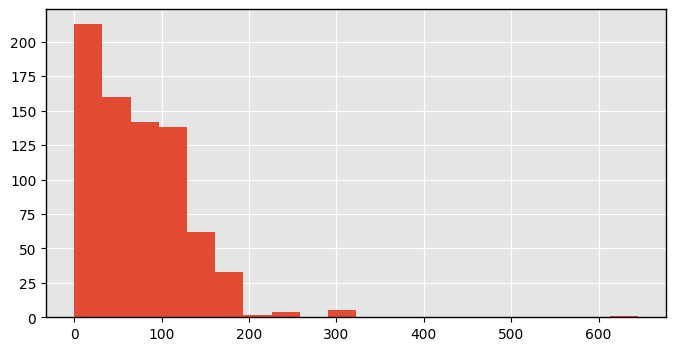

In [35]:
competition = train_data.loc[train_data.Competition == 1].groupby("Store").agg({
    "CompetitionMonthsTotal": "first"
})

fig, ax = plt.subplots(figsize=(8,4))

ax.hist(competition, bins=20)